# PLURALSIGHT TAKE-HOME

By Oliver Proudfoot 

April 7th, 2022

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
trainingDF = pd.read_csv('recruiting_zeta-disease_training-data_take-home-challenge - 2021_zeta-disease_training-data_take-home-challenge.csv')
trainingDF

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0
...,...,...,...,...,...,...,...,...,...
795,26,161,28.4,90,78,0.5578,42,3,0
796,37,165,33.7,60,0,0.3078,69,6,1
797,27,166,25.6,74,0,0.2638,0,5,0
798,109,139,28.1,66,94,0.2298,53,1,0


## Checking for outliers & missing values

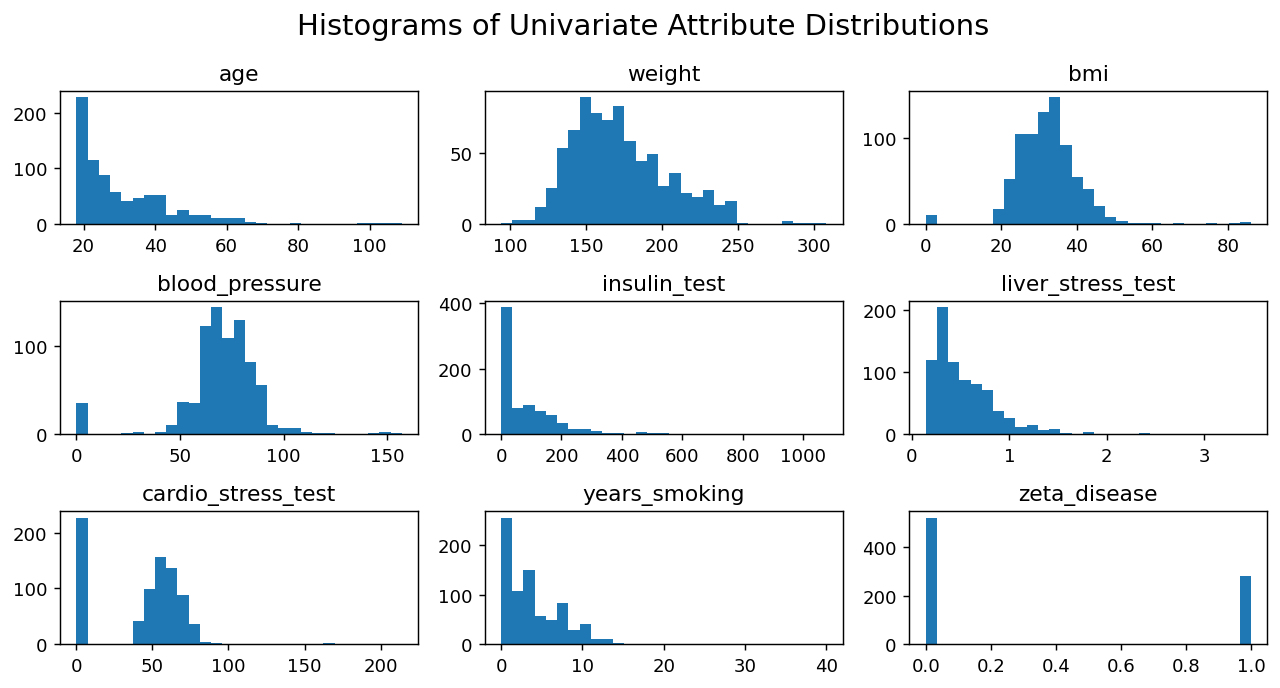

In [4]:
fig = plt.figure(figsize=(10,5),dpi=130)
for i,col in enumerate(trainingDF.columns):
    plt.subplot(3,3,i+1)
    plt.hist(trainingDF[col],bins=int(np.ceil(np.sqrt(800))))
    plt.title(col)
fig.tight_layout()
plt.suptitle("Histograms of Univariate Attribute Distributions", fontsize=16, y=1.05)
plt.show()

```blood_pressure```, ```insulin_test```, ```bmi```, and ```cardio_stress_test``` have zeroed out missing values. 

The value range for all other variables seems plausible. There are possible outliers which I will check for using multivariate analysis with mahalanobis distance.

## Fixing Missing Values
### Replacing '0's with NaN

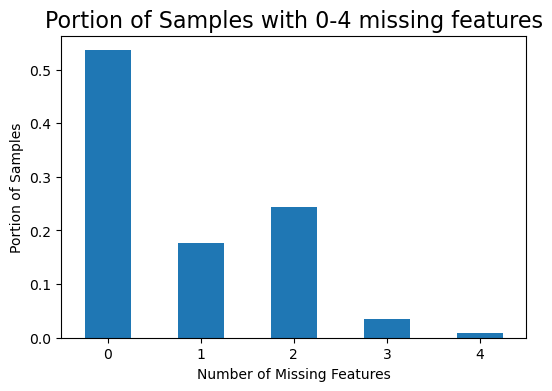

In [5]:
missingCols = ['blood_pressure', 'insulin_test', 'bmi', 'cardio_stress_test']
for col in missingCols:
    mask = trainingDF[col]==0
    trainingDF.loc[mask,col] = np.nan

out = pd.cut(trainingDF.isnull().sum(1), bins=[-1, 0, 1, 2, 3, 4], include_lowest=True)
out_norm = out.value_counts(sort=False, normalize=True)
plt.figure(dpi=100)
ax = out_norm.plot.bar(rot = 0)
ax.set_xticklabels([str(interval)[-4] for interval in out.cat.categories])
plt.ylabel("Portion of Samples")
plt.title("Portion of Samples with 0-4 missing features", fontsize=16)
plt.xlabel("Number of Missing Features")
plt.show()    

### Imputing Missing Data

Since almost half of our data is missing 1 or 2 values, we'll try to impute these values. We'll drop data missing 3 or 4 values. 

In [6]:
trainingDF.drop(trainingDF[trainingDF.isnull().sum(1)>2].index, inplace=True)

**I'm operating under the assumption that data is missing at random.** (i.e. missing data does not convey information)
   - Why? The prediction data has no missing values.
   
**Method for Imputing Data:**

We'll try something simple at first, and if cross-validation results are good, we'll roll with it.
```sklearn.impute.KNNImputer``` takes a DF and, by default, uses an average of the 5 nearest neighbors to impute the missing dimension. There are options for varying the number of neighbors and weighting the average; however, I won't explore these options in the interest of time. More info [here](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html).

In [7]:
from sklearn.impute import KNNImputer

In [8]:
imputedDF = pd.DataFrame(KNNImputer().fit_transform(trainingDF),index=trainingDF.index,columns=trainingDF.columns)

## Multivariate Outliers

In [9]:
from scipy.spatial.distance import mahalanobis as mdist
from scipy.stats import chi2
features = imputedDF[imputedDF.columns[::-1]]
centroid = features.mean(axis=0).to_numpy()             #center of data
icov = np.linalg.inv(features.cov())                    #inverted covariance for mahalanobis distance
critical = np.sqrt(chi2.ppf(.99,len(features.columns))) #chi squared for squared distance

dist_from_center = np.fromiter((mdist(centroid,row,icov) for row in features.values),float)

outlier_mask = dist_from_center>critical
print("Number of outliers outside chi2 99th percentile:",sum(outlier_mask))
print("\nSAMPLE 411:")
imputedDF.loc[411]

Number of outliers outside chi2 99th percentile: 47

SAMPLE 411:


age                    60.0000
weight                151.0000
bmi                    76.6000
blood_pressure         76.0000
insulin_test          180.0000
liver_stress_test       0.2338
cardio_stress_test     78.0000
years_smoking          10.0000
zeta_disease            0.0000
Name: 411, dtype: float64

Finding multivariate outliers catches cases such as sample `411`. A BMI of `76.6` indicates morbid obesity; however, at `151 lbs`, if the formula for BMI is $$\text{BMI} = 703\times \frac{w_{lbs}}{h_{in}^2},$$ then sample `411` would have to be roughly `16` inches tall!

We'll drop all of these samples.

In [10]:
imputedDF.drop(imputedDF[outlier_mask].index, inplace=True) #DROP OUTLIERS

## Feature Engineering

We may be able to further separate susceptibility to zeta disease in hyperspace by considering non-linear combination of features. 

An obvious feature we can engineer is height. $$h_{in} = \sqrt{\frac{703\times w_{lbs}}{\text{BMI}}}$$

Another is `age` $\times$ `*_test`, where `*_test` is any of the test features, which presumably indicate organ health. This feature may provide information on the cause of unhealthy organs -- whether due to age or disease.

Similarly, `years_smoking` $\times$ `*_test` could differentiate between unhealthy organs due to smoking or disease.

This amounts to 7 features.

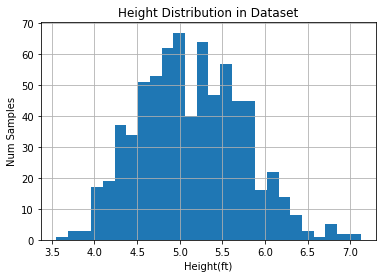

In [11]:
height = np.sqrt(703*imputedDF['weight']/imputedDF['bmi'])
(height/12).hist(bins=int(np.sqrt(718)))
plt.xlabel("Height(ft)")
plt.ylabel("Num Samples")
plt.title("Height Distribution in Dataset")
plt.show()

In [12]:
testCols = ['insulin_test', 'liver_stress_test', 'cardio_stress_test']
ageFtrs = (imputedDF[testCols].T*imputedDF['age']).T
ageFtrs.columns = ['age_'+name for name in testCols]

smokingFtrs = (imputedDF[testCols].T*imputedDF['years_smoking']).T
smokingFtrs.columns = ['smoking_'+name for name in testCols]

engineeredDF = pd.concat((ageFtrs,smokingFtrs,height,imputedDF),axis=1)
engineeredDF.rename(columns={0:"height"},inplace=True)

## Model Selection

In [13]:
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

### Feature Elimination
Due to possible redundency from adding features, I'll select features to use by doing recursive feature elimination. The RFE class removes at each step the least informative feature. Since different models may find feature geometry useful in different ways, we'll restrict them to 6 features each and then take the union of their selected features.

In [14]:
X,y = engineeredDF.iloc[:,:-1],engineeredDF.iloc[:,-1]
selectorLR = RFE(LogisticRegression(max_iter=10000), n_features_to_select=6, step=1).fit(X, y)
selectorRF = RFE(RandomForestClassifier(), n_features_to_select=6, step=1).fit(X, y)
feature_mask = selectorLR.support_+selectorRF.support_
print("Number of Features Selected:",sum(feature_mask))

Number of Features Selected: 10


In [15]:
def plotF1contour():
    """Plots F1 contours"""
    grid = np.linspace(0.001, 1, 100)
    gridx, gridy = np.meshgrid(grid, grid)
    F1 = 2* gridx*gridy/(gridx+gridy)
    CS = plt.contour(gridx,gridy,F1,levels=9,alpha=.3)   # Plot Contours
    plt.clabel(CS, inline=1, fontsize=10)                # Add Labels to Lines

def compare_models(x_tr: pd.DataFrame,
                   x_te: pd.DataFrame,
                   y_tr: pd.DataFrame,
                   y_te: pd.DataFrame,):
    """
    Function designed to test a variety of models on a dataset.
    Inputs:
    ------
        x_tr: pd.DataFrame,
            Features to train on.
        x_te: pd.DataFrame,
            Features to test on.
        y_tr: pd.DataFrame,
            Labels to train on.
        y_te: pd.DataFrame,
            Labels to test on.
    
    Returns:
    -------
        scores: pd.DataFrame,
            Array of 6 metrics for each of the 6 classifiers.
    """
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1) # 50 Fold Cross Validation
    
    models = [
        ("LinearSVM", SVC()),                            # Margin Maximation
        ("RF", RandomForestClassifier()),                # Non-linear data geometry
        ("Logit", LogisticRegression(max_iter=10000)),   # Low info, linear decision plane
        ("GradientBF", GradientBoostingClassifier()),    # Non-linear can be tuned better than RF
        ("KNN", KNeighborsClassifier()),                 # Classic Algorithm, Easy Implementation
        ("NaiveBayes", GaussianNB())                     # Assumes Independence of Features, Probability based
    ]
    
    scoring = [
        'accuracy',             # Proportion of correct predictions
        'precision_weighted',   # TP/(TP+FP)
        'recall_weighted',      # TP/(TP+FN)
        'f1_weighted',          # 2*PR*RC/(PR+RC)
        'roc_auc',              # Area under the ROC curve (Recall(TPR) and FPR)
        'average_precision'     # Area under the PR curve
    ]
    
    scores = []
    names = []
    fig = plt.figure(dpi=120,figsize=(6,6))
    ax = plt.gca()
    for name, clf in models:
        
        #CROSS VALIDATION
        scores.append([
            np.mean(val) 
            for key,val in cross_validate(clf, x_tr, y_tr, cv=cv, scoring=scoring).items() 
            if key[:5]=="test_"
        ])
        names.append(name)
        
        #PLOT
        clf.fit(x_tr,y_tr)
        PrecisionRecallDisplay.from_estimator(clf, x_te, y_te,ax=ax)
        
    plt.plot([0,1],[np.mean(y_te)]*2,'--',label="No Skill")
    plt.axis("square")
    plotF1contour()
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend()
    plt.title("PR Curve for Various Classifiers \nw/ F1 Contours")
    plt.show()
    
    return pd.DataFrame(scores, columns = scoring, index=names)

### Model Comparison

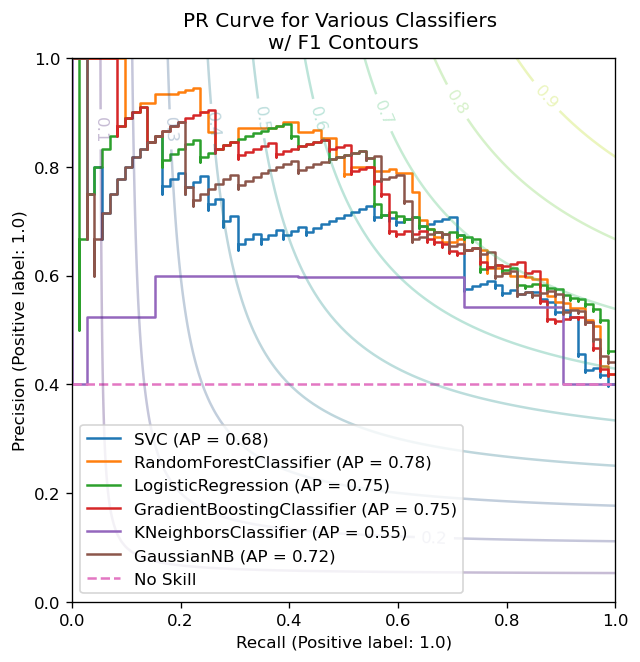

,accuracy,precision_weighted,recall_weighted,f1_weighted,roc_auc,average_precision
LinearSVM,0.672446,0.645946,0.672446,0.636115,0.723189,0.529560
RF,0.783326,0.779091,0.783326,0.775523,0.839482,0.722911
Logit,0.792949,0.789607,0.792949,0.783210,0.846679,0.723305
GradientBF,0.777736,0.775805,0.777736,0.772373,0.838125,0.725983
KNN,0.688078,0.678581,0.688078,0.677244,0.721840,0.501157
NaiveBayes,0.746198,0.745845,0.746198,0.744209,0.816852,0.647053


In [16]:
X_train,X_test,y_train,y_test = train_test_split(X.loc[:,feature_mask],y,random_state=333)
compare_models(X_train,X_test,y_train,y_test).style.highlight_max(color = 'yellow', axis = 0)

Clearly, logistic regression wins the day in almost every metric besides mAP. We'll tune it and have it be our final model. 

## Model Hyperparameter Tuning

We can tune `C` or `penalty`; however, l2-regularization will work. `C` is the regularization constant.

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

X,y = engineeredDF.iloc[:,:-1],engineeredDF.iloc[:,-1]
selectorLR = RFE(LogisticRegression(max_iter=10000), n_features_to_select=12, step=1).fit(X, y).support_
X = X.loc[:,selectorLR]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
C_range = np.logspace(-2,2,31)
param_grid = dict(C=C_range)

grid = GridSearchCV(LogisticRegression(max_iter=10000), param_grid=param_grid, cv=cv, verbose=1, n_jobs=-1)

res = grid.fit(X, y)
print(res.best_params_)
print(res.best_score_)

Fitting 50 folds for each of 31 candidates, totalling 1550 fits
{'C': 0.15848931924611134}
0.7780712050078248


## Final Model Training and Evaluation

In [18]:
unlabeled = pd.read_csv("recruiting_zeta-disease_prediction-data_take-home-challenge - 2021-01-21_zeta-disease_prediction-data_take-home-challenge.csv")

#ENGINEERED FEATURES

height = np.sqrt(703*unlabeled['weight']/unlabeled['bmi'])

testCols = ['insulin_test', 'liver_stress_test', 'cardio_stress_test']
ageFtrs = (unlabeled[testCols].T*unlabeled['age']).T
ageFtrs.columns = ['age_'+name for name in testCols]

smokingFtrs = (unlabeled[testCols].T*unlabeled['years_smoking']).T
smokingFtrs.columns = ['smoking_'+name for name in testCols]

unlabeledX = pd.concat((ageFtrs,smokingFtrs,height,unlabeled),axis=1)
unlabeledX.rename(columns={0:"height"},inplace=True)
unlabeledX = unlabeledX.iloc[:,:-1]

#TRAIN MODEL

model = LogisticRegression(max_iter=10000,**res.best_params_).fit(X,y)
yhat = model.predict(unlabeledX.loc[:,selectorLR])

unlabeled['zeta_disease']=yhat
print(yhat)
unlabeled


[0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]


,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,0.0
1,27,179,35.5,89,156,1.6608,43,6,1.0
2,34,147,26.9,76,74,1.6958,53,2,0.0
3,35,206,32.4,73,127,1.4608,61,6,1.0
4,60,193,29.8,62,192,1.7798,65,9,1.0
5,45,120,36.5,108,50,1.2978,54,12,1.0
6,20,139,38.2,61,77,1.5818,68,3,0.0
7,23,137,31.2,70,73,1.4168,59,7,0.0
8,36,195,30.5,59,141,1.4498,59,6,1.0
9,19,193,25.8,84,66,1.7938,50,3,0.0


## Discussion
There seems to be a pretty high proportion of predicted cases in this set of data; further, the people do seem to be almost all obese. 

The decision boundary may want to be shifted to make the model more sensitive to zeta-disease. Diseases typically aren't very prevalent but can be very costly, so recall is more valuable than precision. A less precise test can lead to further and more precise tests. As an initial screening, this model seems effective.